In [339]:
# Import packages
import pandas as pd
import re
from gensim.parsing.preprocessing import STOPWORDS, strip_tags, strip_numeric, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_short, stem_text
import pickle
import en_core_web_sm
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = "whitegrid")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\svawe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Part A

In [6]:
df = pd.read_json("https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json")

In [8]:
df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [26]:
print(df.content[0])
#definetly fits the "autos" category

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [28]:
print(df.content[1])
#fits the hardware category

From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final call for SI clock reports
Keywords: SI,acceleration,clock,upgrade
Article-I.D.: shelley.1qvfo9INNc3s
Organization: University of Washington
Lines: 11
NNTP-Posting-Host: carson.u.washington.edu

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. Thanks.

Guy Kuo <guykuo@u.washington.edu>



In [40]:
target_names = list(df.target_names)
cat = []
for i in target_names:
    cat.append(i[0:i.find('.')])
    
df["category"] = cat

In [ ]:
df.head()

,content,target,target_names,category
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos,rec
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware,comp
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware,comp
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics,comp
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space,sci


In [44]:
df2 = df.groupby("target_names").target.count().reset_index()
df2.head()

,target_names,target
0,alt.atheism,480
1,comp.graphics,584
2,comp.os.ms-windows.misc,591
3,comp.sys.ibm.pc.hardware,590
4,comp.sys.mac.hardware,578


In [322]:
df3 = df.groupby("category").target.count().reset_index()
df3
#comp, rec, sci and talk are the leading categories

,category,target
0,alt,480
1,comp,2936
2,misc,585
3,rec,2389
4,sci,2373
5,soc,599
6,talk,1952


<AxesSubplot:xlabel='count', ylabel='target_names'>

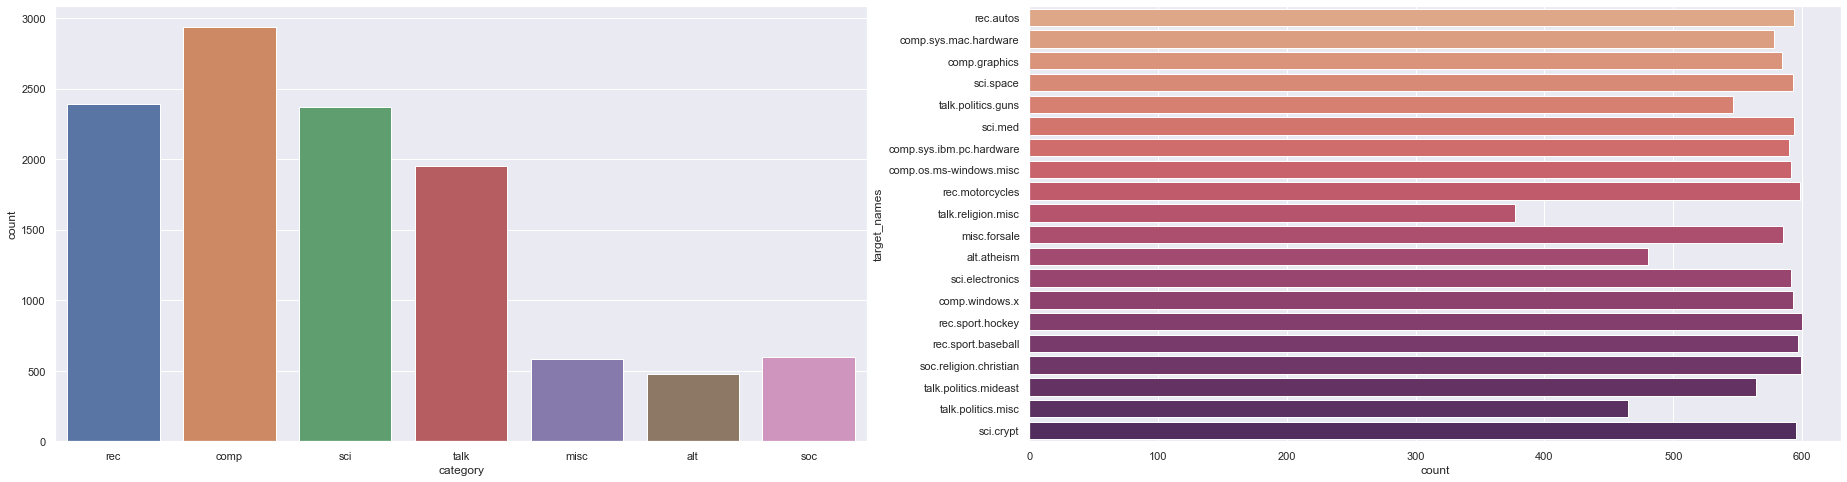

In [323]:
sns.set(font_scale = 1)
fig, ax =plt.subplots(1,2, figsize = (32,8))
sns.countplot(x = "category", data = df, ax = ax[0])
sns.countplot(y = "target_names", data = df, ax = ax[1], palette = "flare") 
#particularly on none-combined categories, the counts almost follow an uniform distribution

# Part B

In [257]:
data = []
for i in df.content:
    cl_1 = re.findall("(?m)^(?!From:.*|^Article-I.D.:.*|^NNTP-Posting-Host:.*|^Organization:.*|^Lines:.*|^Distribution:.*|^Reply-To:.*|^X-Newsreader:.*|^Expires:.*|^ *-+.*).*", i, flags = re.IGNORECASE)
    cl_2 = re.sub("Subject: |Summary: |Keywords:","", " ".join(cl_1), flags = re.IGNORECASE)
    data.append(cl_2)
#this cleaning removed unnecessary lines and words (duh)

In [256]:
data[4]

'Re: Shuttle Launch Question  From article <C5owCB.n3p@world.std.com>, by tombaker@world.std.com (Tom A Baker): >>In article <C5JLwx.4H9.1@cs.cmu.edu>, ETRAT@ttacs1.ttu.edu (Pack Rat) writes... >>>"Clear caution & warning memory.  Verify no unexpected >>>errors. ...".  I am wondering what an "expected error" might >>>be.  Sorry if this is a really dumb question, but >  > Parity errors in memory or previously known conditions that were waivered. >    "Yes that is an error, but we already knew about it" > I\'d be curious as to what the real meaning of the quote is. >  > tom   My understanding is that the \'expected errors\' are basically known bugs in the warning system software - things are checked that don\'t have the right values in yet because they aren\'t set till after launch, and suchlike. Rather than fix the code and possibly introduce new bugs, they just tell the crew \'ok, if you see a warning no. 213 before liftoff, ignore it\'.    '

# Part C

In [265]:
data_stripped = []
for i in data:
    text = i.lower() #remove upper case letters to allow grouping
    #text = remove_stopwords(text)
    text = strip_punctuation(text) #remove all instances of . and : 
    #text = strip_tags(text)
    text = strip_numeric(text) #remove all numbers (because uninterpretable, i guess)
    text = strip_multiple_whitespaces(text) #remove dupplicate spaces
    #text = strip_short(text)
    data_stripped.append(text)

# Part D

In [290]:
stops = list(set(stopwords.words('english')))

In [291]:
len(stops), len(STOPWORDS)
#obviously the STOPWORDS list from gensim is a lot longer

(179, 337)

In [296]:
stops.sort()
stops[:10]

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']

In [319]:
genstops = list(STOPWORDS)
genstops.sort()
genstops[:8] #it seems like the genstops list is more in-depth

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against']

In [347]:
#count the number of words that are unique to the gensim list
only_gensim = []
for i in genstops:
    if stops.count(i) == 0: only_gensim.append(i)

#count the number of words that are unique to the nltk list
only_nltk = []
for i in stops: 
    if genstops.count(i) == 0: only_nltk.append(i)
#print length of both lists to show comparison
len(only_nltk), len(only_gensim)

(53, 211)

In [348]:
only_nltk[:7]
#seems like the words that are extra in the nltk list are mainly variations of words that are being abbreviated

['ain', 'aren', "aren't", 'couldn', "couldn't", 'd', "didn't"]

In [349]:
data_nostop = []
for i in data_stripped:
    text = strip_short(i) #removes many short words and single letters, such as "70s" -> strip numeric = "s" -> strip short = ""
    data_nostop.append(remove_stopwords(text))

In [350]:
data_stripped[0]

'what car is this i was wondering if anyone out there could enlighten me on this car i saw the other day it was a door sports car looked to be from the late s early s it was called a bricklin the doors were really small in addition the front bumper was separate from the rest of the body this is all i know if anyone can tellme a model name engine specs years of production where this car is made history or whatever info you have on this funky looking car please e mail thanks '

In [351]:
data_nostop[0]

'car wondering enlighten car saw day door sports car looked late early called bricklin doors small addition bumper separate rest body know tellme model engine specs years production car history info funky looking car mail thanks'

# Part E

In [352]:
data_stem = []
for i in data_nostop: data_stem.append(stem_text(i)) 
#the function reduces the words to their origin, 
#this means that similar words will be reduced to the same origin and will be treated identically

In [353]:
data_stem[0]

'car wonder enlighten car saw dai door sport car look late earli call bricklin door small addit bumper separ rest bodi know tellm model engin spec year product car histori info funki look car mail thank'

In [354]:
nlp = en_core_web_sm.load()

In [360]:
data_lem = []
for i in data_nostop: 
    lemma = nlp(i)
    data_lem.append(" ".join([word.lemma_ for word in lemma]))

In [361]:
data_lem[0]

'car wonder enlighten car see day door sport car look late early call bricklin door small addition bumper separate rest body know tellme model engine spec year production car history info funky look car mail thank'

In [362]:
data_nostop[0]

'car wondering enlighten car saw day door sports car looked late early called bricklin doors small addition bumper separate rest body know tellme model engine specs years production car history info funky looking car mail thanks'

In [ ]:
#for google collab:
#from google.colab import drive
#drive.mount('/content/drive')
#pickle.dump